## Sección de Librerías

In [1]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg
import pypfopt
from pypfopt import EfficientFrontier,plotting

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [2]:
#Opciones precargadas de índices a utilizar para evaluar. 
sp500_components = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].to_list()
sp100_components = pd.read_html('https://www.infobolsa.es/acciones/sp100')[0]['Ticker'].to_list()
dowjones_components = pd.read_html('https://www.infobolsa.es/acciones/dowjones')[0]['Ticker'].to_list()
nasdaq100_components = pd.read_html('https://www.infobolsa.es/acciones/nasdaq')[0]['Ticker'].to_list()
dax40_components = pd.read_html('https://www.infobolsa.es/acciones/dax30')[0]['Ticker'].to_list()
eurostoxx50_components = pd.read_html('https://www.infobolsa.es/acciones/eurostoxx50')[0]['Ticker'].to_list()

## Primera parte obtención de los activos para el portafolio

In [3]:
assets = dowjones_components
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  30 of 30 completed


In [4]:
#Obtenemos información de los activos 
#- retornos logaritmicos 
#- profits: Retorno medio esperado. 
#- risk: Desviación estándar del activo. 
returns, assets_info= pre_processing.get_assets_info(prices, 0.99, log_returns=True)

In [5]:
best_assets = ArchievingStrategies.get_best_opt(assets_info, 1e-6)

30it [00:00, 10008.68it/s]


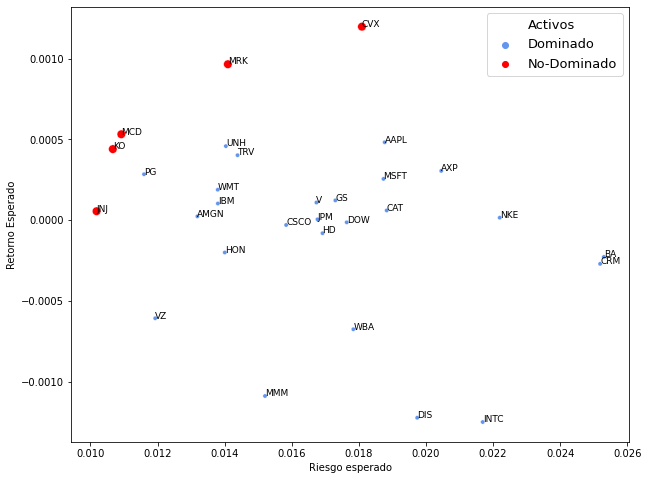

In [6]:
my_plotting.plot_assets(assets_info, best_assets)


## Segunda Parte Definición del Problema

In [7]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK)

## Tercera parte solución con pesos aleatorios

In [8]:
Xrandom_weights = get_reference_directions("das-dennis", len(PROFITS), n_partitions=12)
Frandom = pymoo_extras.eval_weights(portfolio_problem, Xrandom_weights)

In [9]:
Frandom_best = ArchievingStrategies.get_best_opt(Frandom, 1e-8)
Frandom_best_eps = ArchievingStrategies.get_best_opt_eps(Frandom, 1e-8, [0.00001, 0.0001])
Frandom_best_H   = ArchievingStrategies.get_best_opt_eps_H(Frandom, 1e-8, [0, 0], 0.01) #Muy sensible a las normas 
frames = [Frandom, Frandom_best_eps, Frandom_best, Frandom_best_H]
labels = ['Todos', 'PQ-eps', 'PQ', 'PQ-eps-H']

1820it [00:00, 26001.62it/s]
1820it [00:00, 7081.85it/s]
1820it [00:00, 16546.87it/s]


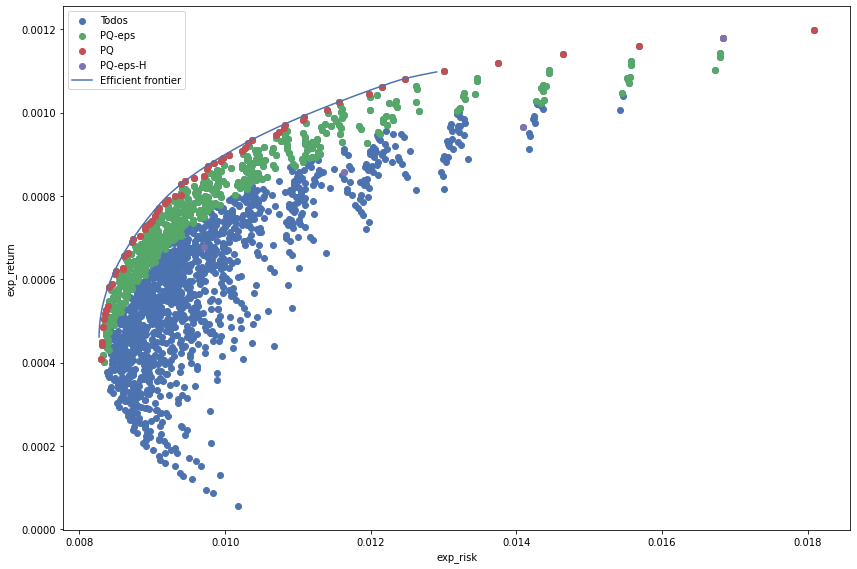

In [10]:
my_plotting.plotting_samples(PROFITS, RISK, frames, labels, (12,8))

## Cuarta parte solución con pesos obtenidos por medio de un algoritmo de optimización

In [11]:
#Criterio para terminar (300 generaciones)
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
ref_dirs = get_reference_directions("energy", 2, n_points=99)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=100,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=100, repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.nsga3 import NSGA3
nsgaiii = NSGA3(pop_size=100,ref_dirs=ref_dirs, repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.moead import MOEAD
moead = MOEAD( ref_dirs=ref_dirs, repair=pymoo_extras.Portfolio_Repair())

In [13]:
#En la segunda entrada se puede cambiar el algoritmo a utilizar por alguno de los definidos arriba 
#nsgaii, smsemoa, nsgaiii, moead, los que dan mejores resultados son nsgaii y smsemoa 
X, pdF =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)



In [14]:
pdF_best = ArchievingStrategies.get_best_opt(pdF, 1e-8)
pdF_best_eps = ArchievingStrategies.get_best_opt_eps(pdF, 1e-8, [0.00001, 0.0001])
pdF_best_H   = ArchievingStrategies.get_best_opt_eps_H(pdF, 1e-8, [0, 0], 0.01) #Muy sensible a las normas 
frames = [pdF, pdF_best_eps, pdF_best, pdF_best_H]
labels = ['Todos NSGAII', 'PQ-eps', 'PQ', 'PQ-eps-H']

30000it [00:07, 4180.47it/s]
30000it [01:32, 322.89it/s]
30000it [00:01, 15706.88it/s]


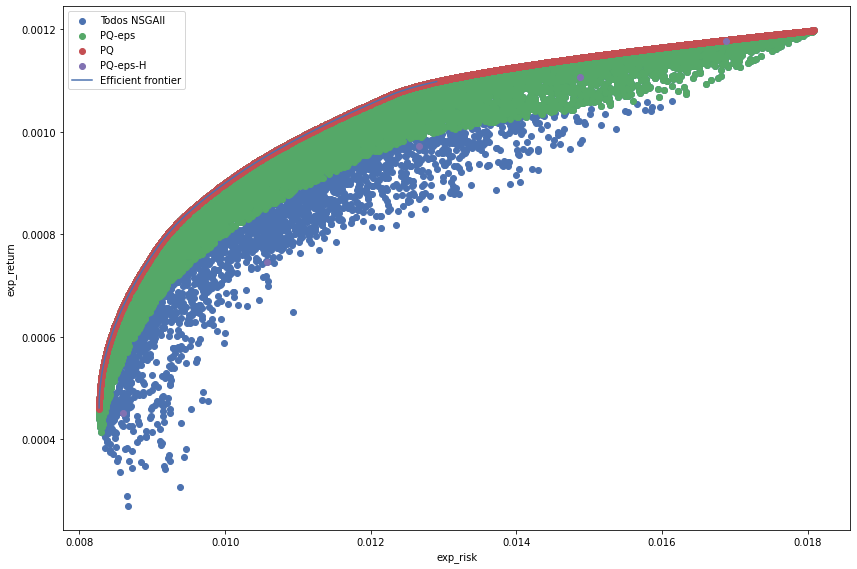

In [15]:
my_plotting.plotting_samples(PROFITS, RISK, frames, labels, (12,8))